# Hisse senedi fiyat tahminlemesi
* iş problemi
* veriyi anlama
* veriyi hazırlama
* modelleme
* değerlendirme

# İş problemi: hisse seenetlerini daha iyi bir biçimde tahmin etmek
* **Data** : ilgili işlem günün tarigini temsil etmektedir.
* **open** : ilgili işlem gününe ait hisse başlangıç fiyatını temsil etmektedir.
* **high** : ilgili işlem gününe ait en yüksek fiyatı temsil etmektedir.
* **Low** : ilgili işlem gününe ait en düşük fiyatı temsil etmektedir.
* **Close** : ilgili işlem gününende hisse senedi kapanış fiyatı
* **ADJ Close** : ilgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatı
* **Volume** : ilgili işlem gününe ait işlem hacmi

In [1]:
## veriyi okuma ve işleme adımında kullanılacak olan kütphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
## Model değerlendirme ve veriyi scale edebilmek için ;
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#model için kullanılacak kütpahaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#warning..
import warnings
warnings.filterwarnings('ignore')

# Data Undertstanding

In [2]:
df = pd.read_csv('TSLA.csv')

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2416.0,1.862711e+02,1.187402e+02,16.139999,3.434250e+01,2.130350e+02,2.664500e+02,6.736900e+02
High,2416.0,1.895782e+02,1.208923e+02,16.629999,3.489750e+01,2.167450e+02,2.709275e+02,7.861400e+02
Low,2416.0,1.829166e+02,1.168576e+02,14.980000,3.358750e+01,2.088700e+02,2.621025e+02,6.735200e+02
Close,2416.0,1.864037e+02,1.191360e+02,15.800000,3.440000e+01,2.129600e+02,2.667750e+02,7.800000e+02
Adj Close,2416.0,1.864037e+02,1.191360e+02,15.800000,3.440000e+01,2.129600e+02,2.667750e+02,7.800000e+02
Volume,2416.0,5.572722e+06,4.987809e+06,118500.000000,1.899275e+06,4.578400e+06,7.361150e+06,4.706500e+07


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
def check_df(dataframe, head=5):
    print("######### Shape ##########")
    print(dataframe.shape)
    print("######### Types ##########")    
    print(dataframe.dtypes)
    print("######### Head ##########")    
    print(dataframe.head(head))
    print("######### tail ##########")    
    print(dataframe.tail(head))
    print("######### NA ##########")    
    print(dataframe.isnull().sum())
    print("######### Quantiles ##########")
    print(dataframe.quantile([0,0.05,0.5,0.95,0.99,1]).T)
    print("######### describe ##########")
    print(dataframe.describe().T)

In [7]:
check_df(df) # Date object, time a çevirmek lazım. Amacımız günlük kapanışı tahmin etmek. 

######### Shape ##########
(2416, 7)
######### Types ##########
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
######### Head ##########
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
######### tail ##########
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650

# Data prepration

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
tesla_df = df[['Date','Close']]

In [10]:
tesla_df.index = tesla_df.Date

In [11]:
tesla_df.drop('Date',inplace=True,axis=1)

In [12]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [13]:
result_df = tesla_df.copy()

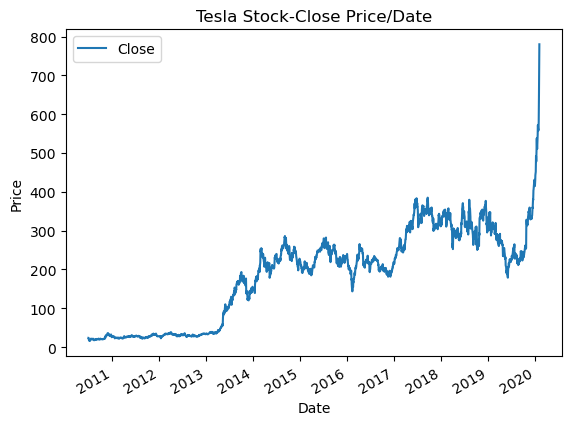

In [14]:
tesla_df.plot()
plt.ylabel('Price')
plt.title('Tesla Stock-Close Price/Date')
plt.show()

In [15]:
tesla_df = tesla_df.values

In [16]:
tesla_df

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [17]:
type(tesla_df)

numpy.ndarray

In [18]:
tesla_df = tesla_df.astype('float32')

#### train test ayrımını yapılması
* dateleri karıştırmamsı için train_test_split fonksiyonu kullanmayacağız ! çünkü zamanın rastgele olmak istemiyoruz

In [19]:
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [20]:
train, test, pos = split_data(tesla_df, 0.20)

In [21]:
test.shape

(483, 1)

# neden standartlaştırıyoruz
* performans optimizasyonu ! 
* birden fazla değişken kullandığımızda da değişkenlerin birbirini ezmemsi için değişken dönüştürme işlemi yapılmasında fayda var ! 

In [22]:
scaler_train =MinMaxScaler(feature_range=(0,1))
scaler_test =MinMaxScaler(feature_range=(0,1))

In [23]:
?MinMaxScaler

Init signature: MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)
Docstring:     
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

The transformation is given by::

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

This transformation is often used as an alternative to zero mean,
unit variance scaling.

Read more in the :ref:`User Guide <preprocessing_scaler>`.

Parameters
----------
feature_range : tuple (min, max), default=(0, 1)
    Desired range of transformed data.

copy : bool, default=True
    Set to False to perform inplace row normalization and avoid a
    copy (if the input is already a numpy array).

clip : bool, default=False
    Set to True to clip transformed values of held-out data to
    provided `feature range`.

In [24]:
train= scaler_train.fit_transform(train)
test= scaler_test.fit_transform(test)

In [25]:
def create_features(data, lookback):
    X,Y = [],[]
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [26]:
lookback = 20

In [27]:
X_train,y_train =create_features(train,lookback)

In [28]:
X_test,y_test =create_features(test,lookback)

* ürettiğimiz bu yeni featurelar aslında teslanın o günkü closer değerinin 20 gün önceki değerleri, yani sonra 20 gün içerisinde bugüne olan yansıma değerler.... biraz karışık ama anladım

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1913, 20), (463, 20), (1913,), (463,))

In [30]:
len(y_train)

1913

In [31]:
X_train

array([[2.1912243e-02, 2.1749731e-02, 1.6684722e-02, ..., 1.4869992e-02,
        1.3949081e-02, 1.2865655e-02],
       [2.1749731e-02, 1.6684722e-02, 9.2091039e-03, ..., 1.3949081e-02,
        1.2865655e-02, 1.3326108e-02],
       [1.6684722e-02, 9.2091039e-03, 8.3965808e-04, ..., 1.2865655e-02,
        1.3326108e-02, 1.2323946e-02],
       ...,
       [8.9387864e-01, 9.1687429e-01, 9.0316898e-01, ..., 9.1075289e-01,
        9.2529792e-01, 9.0788186e-01],
       [9.1687429e-01, 9.0316898e-01, 8.8827187e-01, ..., 9.2529792e-01,
        9.0788186e-01, 8.8640296e-01],
       [9.0316898e-01, 8.8827187e-01, 8.5950702e-01, ..., 9.0788186e-01,
        8.8640296e-01, 8.5354817e-01]], dtype=float32)

In [32]:
X_train= np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test= np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1913, 1, 20), (463, 1, 20), (1913, 1), (463, 1))

# Modelleme

In [33]:
model = Sequential()

In [34]:
model.add(LSTM(units=50, activation='relu',
              input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Optimizasyon ve değerlendirme metrik ayarlanması

In [36]:
model.compile(loss='mean_squared_error', optimizer= 'adam')

In [37]:
callbacks= [EarlyStopping(monitor = 'val_loss', patience=3, verbose =1 , mode='min'),
           ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                          save_best_only=True, save_weights_only=False,verbose=1)]

In [38]:
history= model.fit(x= X_train,y=y_train,
         epochs=100, batch_size =20,
         validation_data=(X_test,y_test),
         callbacks=callbacks,
         shuffle=False)

Epoch 1/100

88/96 [==========================>...] - ETA: 0s - loss: 0.0091    
Epoch 1: val_loss improved from inf to 0.00422, saving model to mymodel.h5
96/96 [==============================] - 2s 6ms/step - loss: 0.0098 - val_loss: 0.0042
Epoch 2/100
89/96 [==========================>...] - ETA: 0s - loss: 0.0060
Epoch 2: val_loss improved from 0.00422 to 0.00384, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 3/100
83/96 [========================>.....] - ETA: 0s - loss: 0.0046
Epoch 3: val_loss improved from 0.00384 to 0.00341, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 4/100
89/96 [==========================>...] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss did not improve from 0.00341
96/96 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 5/100
86/96 [=========================>....] - ETA: 0s - 

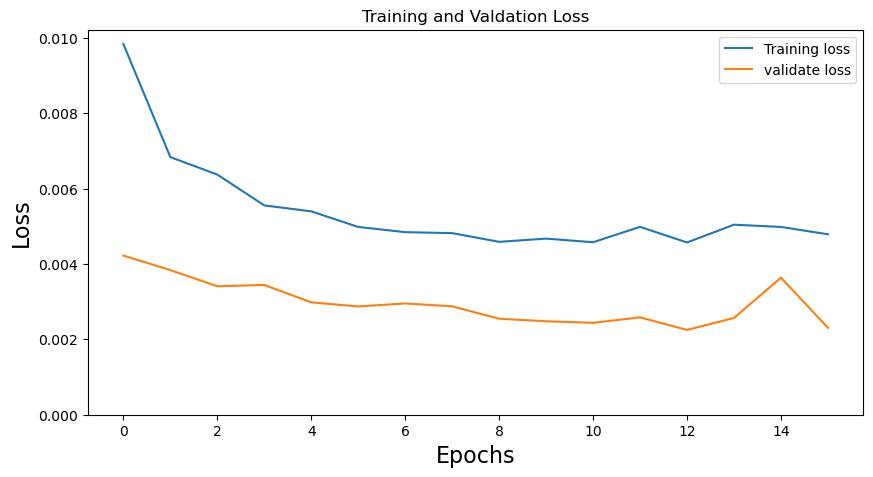

In [39]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'validate loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs' ,fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Valdation Loss')
plt.show()

# Evaluation

In [40]:
loss = model.evaluate(X_test , y_test, batch_size =1)
print("\nTest loss: %.1f%%"% (100.0*loss))

463/463 [==============================] - 1s 1ms/step - loss: 0.0023

Test loss: 0.2%


In [56]:
train_predict = model.predict(X_train)

60/60 [==============================] - 0s 1ms/step


In [60]:
train_predict

array([[ 37.54011],
       [ 37.54011],
       [ 37.54011],
       ...,
       [327.7333 ],
       [328.14667],
       [326.27432]], dtype=float32)

In [58]:
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 1ms/step


In [59]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [44]:
y_test

array([[0.14734703],
       [0.1796416 ],
       [0.21088794],
       [0.20020628],
       [0.18416718],
       [0.20919088],
       [0.20291832],
       [0.1915212 ],
       [0.20193666],
       [0.18674606],
       [0.18088946],
       [0.19030663],
       [0.20150405],
       [0.18513215],
       [0.1737018 ],
       [0.17385152],
       [0.1692428 ],
       [0.17721245],
       [0.1915212 ],
       [0.19122171],
       [0.20123789],
       [0.20328435],
       [0.17549872],
       [0.19153783],
       [0.20597968],
       [0.20464864],
       [0.21276805],
       [0.20972326],
       [0.20313463],
       [0.18801057],
       [0.17504948],
       [0.17887625],
       [0.17564848],
       [0.16280386],
       [0.17556524],
       [0.15979236],
       [0.16654742],
       [0.16451758],
       [0.16618139],
       [0.17435071],
       [0.18759462],
       [0.1759646 ],
       [0.18776101],
       [0.19594693],
       [0.18661296],
       [0.23381528],
       [0.22814164],
       [0.230

In [45]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [46]:
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [47]:
print(f'train : {train_rmse}' + f' test : {test_rmse}')

train : 12.833394050598145 test : 28.86692237854004


In [48]:
result_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [49]:
lookback

20

In [50]:
train_prediction_df = result_df[lookback: pos]
train_prediction_df['Predicted'] = train_predict

In [51]:
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,37.540112
2010-07-29,20.350000,37.540112
2010-07-30,19.940001,37.540112
2010-08-02,20.920000,37.540112
2010-08-03,21.950001,37.540112


In [52]:
train_prediction_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1913.0,158.731636,110.169888,17.600000,31.830000,193.070007,239.490005,385.000000
Predicted,1913.0,162.854462,103.602829,37.540112,39.681709,201.970230,240.950027,354.574158


In [53]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,316.875061
2018-04-04,286.940002,313.055023
2018-04-05,305.720001,310.326599
2018-04-06,299.299988,313.098358
2018-04-09,289.660004,313.015472


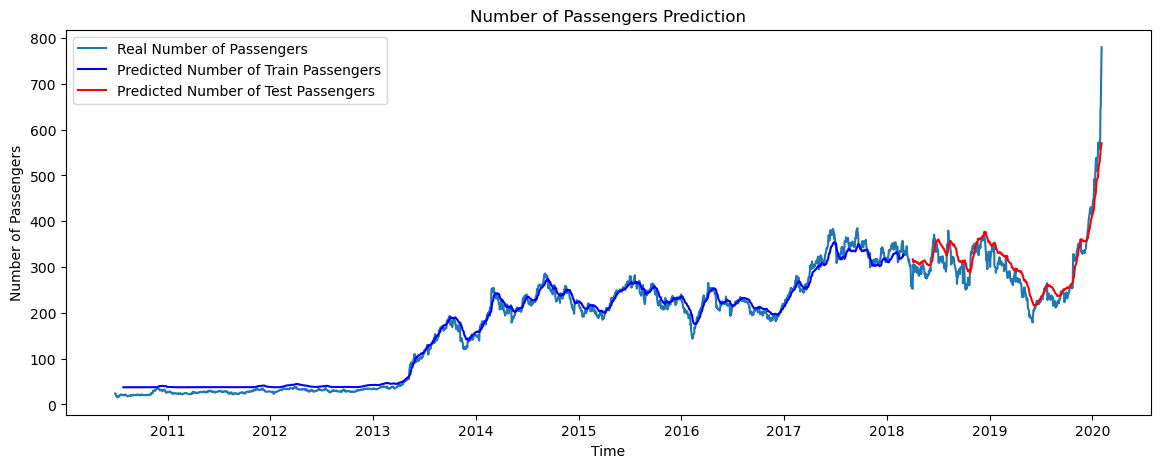

In [54]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label = 'Real Number of Passengers')
plt.plot(train_prediction_df['Predicted'],label = 'Predicted Number of Train Passengers', color='blue')
plt.plot(test_prediction_df['Predicted'],label = 'Predicted Number of Test Passengers', color='red')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()